In [1]:
from pymongo import MongoClient
import datetime
import pandas as pd
import numpy as np
import itertools
import pymongo
from collections import Counter
import pickle

client = MongoClient("localhost", 27017)
db = client["reddit_polarization"]
sw = pickle.load(open("stoplist.pickle"))

In [2]:
men = pd.DataFrame(list(db["MensRights"].find({}, {"author": 1, "score": 1, "subreddit": 1, "_id": 0})))
fem = pd.DataFrame(list(db["Feminism"].find({}, {"author": 1, "score": 1, "subreddit": 1, "_id": 0})))
print men.shape, fem.shape

(2452716, 3) (213100, 3)


In [3]:
author_info = pd.concat([men, fem], axis=0)

In [4]:
def agg_author(df):
    men_mean_score = df[df["subreddit"] == "MensRights"]["score"].mean()
    men_min_score = df[df["subreddit"] == "MensRights"]["score"].min()
    men_max_score = df[df["subreddit"] == "MensRights"]["score"].max()
    men_count = df[df["subreddit"] == "MensRights"]["score"].shape[0]
    
    fem_mean_score = df[df["subreddit"] == "Feminism"]["score"].mean()
    fem_min_score = df[df["subreddit"] == "Feminism"]["score"].min()
    fem_max_score = df[df["subreddit"] == "Feminism"]["score"].max()
    fem_count = df[df["subreddit"] == "Feminism"]["score"].shape[0]
    
    return pd.Series([men_mean_score, men_min_score, men_max_score, men_count,
                      fem_mean_score, fem_min_score, fem_max_score, fem_count],
                     index=["men_mean_score", "men_min_score", "men_max_score", "men_count",
                            "fem_mean_score", "fem_min_score", "fem_max_score", "fem_count"])

In [5]:
authors = author_info.groupby("author").apply(agg_author)

In [6]:
authors[:3]

,men_mean_score,men_min_score,men_max_score,men_count,fem_mean_score,fem_min_score,fem_max_score,fem_count
author,,,,,,,,
---,4.74026,-10.0,30.0,77.0,-2.0,-2.0,-2.0,1.0
------___--___------,1.00000,1.0,1.0,3.0,NaN,NaN,NaN,0.0
----x----,29.00000,29.0,29.0,1.0,NaN,NaN,NaN,0.0


In [7]:
authors.shape

(138029, 8)

In [8]:
115074 + 31772 - 8817

138029

In [210]:
def polarized_authors1(authors, size=2000):
    men_author = authors[authors["men_mean_score"].notnull()][["men_mean_score", "men_min_score",
                                                               "men_max_score", "men_count"]]
    men_author = men_author.reset_index()
    
    fem_author = authors[authors["fem_mean_score"].notnull()][["fem_mean_score", "fem_min_score",
                                                               "fem_max_score", "fem_count"]]
    fem_author = fem_author.reset_index()
    
    # `men_author`: users who posted >= 1 post in `r/MensRights`
    # `fem_author`: users who posted >= 1 post in `r/Feminism`
    # `df`: cross-posters
    df = men_author.merge(fem_author, left_on="author", right_on="author")
    
    men_polar = pd.DataFrame(df[(df["men_min_score"] > 0) & (df["fem_max_score"] <= 0)])
    men_polar["men2fem_diff"] = men_polar["men_mean_score"] - men_polar["fem_mean_score"]
    men_polar = men_polar.sort_values("men2fem_diff", ascending=False)
    
    fem_polar = pd.DataFrame(df[(df["fem_min_score"] > 0) & (df["men_max_score"] <= 0)])
    fem_polar["fem2men_diff"] = fem_polar["fem_mean_score"] - fem_polar["men_mean_score"]
    fem_polar = fem_polar.sort_values("fem2men_diff", ascending=False)

    men_train = pd.DataFrame(df[(df["men_mean_score"] > 0) & (df["fem_mean_score"] < 0)])
    men_train["men2fem_diff"] = men_train["men_mean_score"] - men_train["fem_mean_score"]
    men_train = men_train.sort_values("men2fem_diff", ascending=False)
    men_train = men_train[:size]
    men_train = pd.concat([men_train, men_polar[~men_polar["author"].isin(men_train["author"])]], axis=0)

    fem_train = pd.DataFrame(df[(df["fem_mean_score"] > 0) & (df["men_mean_score"] < 0)])
    fem_train["fem2men_diff"] = fem_train["fem_mean_score"] - fem_train["men_mean_score"]
    fem_train = fem_train.sort_values("fem2men_diff", ascending=False)    
    fem_train = fem_train[:size]
    fem_train = pd.concat([fem_train, fem_polar[~fem_polar["author"].isin(fem_train["author"])]], axis=0)
    
    return men_train, fem_train, men_polar, fem_polar

In [ ]:
def polarized_authors2(authors, size=2000):
    men_author = authors[authors["men_mean_score"].notnull()][["men_mean_score", "men_min_score",
                                                               "men_max_score", "men_count"]]
    men_author = men_author.reset_index()
    
    fem_author = authors[authors["fem_mean_score"].notnull()][["fem_mean_score", "fem_min_score",
                                                               "fem_max_score", "fem_count"]]
    fem_author = fem_author.reset_index()
    
    

In [211]:
men_train, fem_train, men_polar, fem_polar = polarized_authors1(authors, size=300)

In [212]:
# men_polar.shape, fem_polar.shape
# men_train.shape, fem_train.shape

((278, 10), (238, 10))

((492, 10), (448, 10))

In [216]:
def pos_filter(x, keep=set("NJ")):
    if len(x) == 0:
        return ""
    
    tokens_pos = x.split(" ")
    tokens_pos = map(lambda pair: pair.split("/"), tokens_pos)
    
    tokens_pos = filter(lambda pair: pair[1] in keep, tokens_pos)

    if len(tokens_pos) == 0:
        return ""
    
    return " ".join(zip(*tokens_pos)[0])

In [217]:
def clean_token_pos(text):
    text = pos_filter(text)
    out = " ".join(filter(lambda x: x not in sw, text.split(" ")))
    return out

In [218]:
def get_post_of_author(row, subreddit, field, min_word):
    author = row["author"]
    
    post_by_author = list(db[subreddit].find({"author": author}, {field: 1, "score": 1, "_id": 0}))
    post_by_author = map(lambda post: {"score": post["score"], field: clean_token_pos(post[field])}, post_by_author)
    post_by_author = filter(lambda post: len(post[field].split(" ")) >= min_word, post_by_author)
    post_by_author = sorted(post_by_author, key=lambda post: -post["score"])
    post_by_author = [(" ".join([subreddit, author, str(i)]),
                       post_by_author[i]["score"],
                       post_by_author[i][field])
                      for i in range(len(post_by_author))]
    
    return post_by_author

In [219]:
men_polar["post"] = men_polar.apply(lambda row:
                                    get_post_of_author(row, "MensRights", "tokens_njv_pos", 10), axis=1)

In [220]:
fem_polar["post"] = fem_polar.apply(lambda row:
                                    get_post_of_author(row, "Feminism", "tokens_njv_pos", 10), axis=1)

In [221]:
# men_polar["post"].map(len).sum()
# fem_polar["post"].map(len).sum()

434

248

In [223]:
men_polar = men_polar[men_polar["post"].map(len) > 0]

In [224]:
fem_polar = fem_polar[fem_polar["post"].map(len) > 0]

In [225]:
men_polar.shape, fem_polar.shape

((151, 11), (115, 11))

In [226]:
men_train["post"] = men_train.apply(lambda row:
                                    get_post_of_author(row, "MensRights", "tokens_njv_pos", 10), axis=1)

In [227]:
fem_train["post"] = fem_train.apply(lambda row:
                                    get_post_of_author(row, "Feminism", "tokens_njv_pos", 10), axis=1)

In [228]:
men_train = men_train[men_train["post"].map(len) > 0]
fem_train = fem_train[fem_train["post"].map(len) > 0]

In [229]:
men_train["post"].map(len).sum(), fem_train["post"].map(len).sum()

(19494, 1811)

In [230]:
men_train.shape, fem_polar.shape

((339, 11), (115, 11))

In [231]:
from gensim.models.doc2vec import Doc2Vec, LabeledSentence

In [232]:
class PolarizedPost(object):
    def __init__(self, men_train, fem_train):
        self.data = (("men", men_train), ("fem", fem_train))
    def __iter__(self):        
        for subreddit, df in self.data:
            for i in range(df.shape[0]):
                posts = df.iat[i, -1]
                for tag, _, text in posts:
                    yield LabeledSentence(text.split(), [tag])

In [233]:
pp = PolarizedPost(men_train, fem_train)

In [234]:
lpp = list(iter(pp))

In [235]:
len(lpp)

21305

In [236]:
lpp[0].tags

[u'MensRights AmerikanInfidel 0']

In [239]:
models = [Doc2Vec(dm=0, dbow_words=1, min_count=1, window=10,
                  size=200, sample=1e-5, iter=50, workers=4), # Distributed BOW
          Doc2Vec(dm=1, dm_mean=1, min_count=1, window=10,
                  size=100, sample=1e-5, iter=12, workers=4)] # Distributed Memory

names = ["Distributed BOW", "Distributed Memory"]
model = models[0]
name = names[0]

In [240]:
print "%s: %s" % (name, str(model))
corpus = PolarizedPost(men_train, fem_train)
model.build_vocab(corpus)
corpus = PolarizedPost(men_train, fem_train)
model.train(corpus)

Distributed BOW: Doc2Vec(dbow+w,d200,n5,w10,s1e-05,t4)


9355967

In [241]:
model

In [242]:
lpp[:5]

[TaggedDocument(words=[u'yu', u'chinese', u'citizen', u'poughkeepsie', u'york', u'school', u'federal', u'court', u'wrongful', u'expulsion', u'irreparable', u'personal', u'damage', u'sex', u'discrimination', u'complaint', u'victim', u'campus', u'judicial', u'system', u'practice', u'presumes', u'male', u'sexual', u'misconduct', u'guilty', u'good', u'luck'], tags=[u'MensRights AmerikanInfidel 0']),
 TaggedDocument(words=[u'relevant', u'quote', u'pdf', u'lazy', u'page', u'sex', u'percent', u'male', u'percent', u'female', u'poverty', u'subreddit'], tags=[u'MensRights bobotheking 0']),
 TaggedDocument(words=[u'fucking', u'video', u'actual', u'worthwhile', u'impactful', u'content', u'bunch', u'low-res', u'low', u'frame', u'rate', u'hogging', u'mute', u'gifs', u'wrong', u'internet', u'today', u'insulting', u'real', u'content', u'dozen', u'time', u'reddit'], tags=[u'MensRights HIFW_GIFs_React_ 0']),
 TaggedDocument(words=[u'man', u'weak', u'raped', u'man', u'horrible', u'line', u'thinking', u's

In [243]:
X = np.array([model.docvecs[tagged_sent.tags[0]] for tagged_sent in lpp])

In [244]:
X.shape

(21305, 200)

In [245]:
model.most_similar("rapist")

[(u'rape', 0.6596007347106934),
 (u'date-rape', 0.6083933711051941),
 (u'proved', 0.603354811668396),
 (u'acquit', 0.6012427806854248),
 (u'definion', 0.5995047092437744),
 (u'unconsensual', 0.5994706153869629),
 (u'unconsentual', 0.5977901816368103),
 (u'universities', 0.5968244075775146),
 (u'shittiness', 0.5951771140098572),
 (u'dowm', 0.5951663851737976)]

In [246]:
def docvecs_of_author(row, subreddit):    
    tag = row["post"][0][0]
    
    return pd.Series([model.docvecs[tag]])

In [247]:
men_polar["vec"] = men_polar.apply(lambda row: docvecs_of_author(row, "MensRights"), axis=1)

In [249]:
fem_polar["vec"] = fem_polar.apply(lambda row: docvecs_of_author(row, "Feminism"), axis=1)

In [268]:
men_train["vec"] = men_train.apply(lambda row: docvecs_of_author(row, "MensRights"), axis=1)

In [269]:
fem_train["vec"] = fem_train.apply(lambda row: docvecs_of_author(row, "Feminism"), axis=1)

In [270]:
X_men = np.array([v for v in men_train["vec"]])

In [271]:
X_fem = np.array([v for v in fem_train["vec"]])

In [272]:
X_men.shape

(339, 200)

In [273]:
X_fem.shape

(277, 200)

In [274]:
x_men = np.array([posts[0][1] for posts in men_polar["post"]])

In [275]:
x_fem = np.array([posts[0][1] for posts in fem_polar["post"]])

In [276]:
x_men.min()

1

In [277]:
x_fem.min()

1

In [278]:
from sklearn.manifold import TSNE

In [279]:
tsne = TSNE(n_components=2)

In [280]:
X_tsne = tsne.fit_transform(np.r_[X_men, X_fem])

In [281]:
X_tsne.shape

(616, 2)

In [282]:
import matplotlib.pyplot as plt
import seaborn as sns

In [283]:
plt.scatter(X_tsne[:151, 0], X_tsne[:151, 1], c="r", alpha=0.3, linewidths=0.1)
plt.scatter(X_tsne[151:, 0], X_tsne[151:, 1], c="b", alpha=0.3, linewidths=0.1)

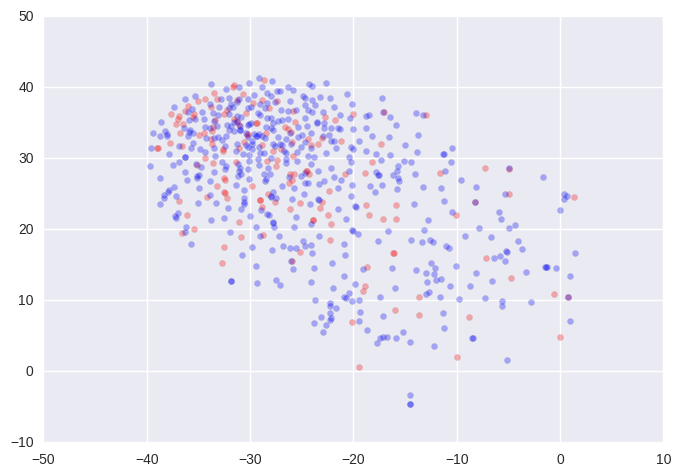

In [284]:
plt.show()